# Representation with a Feature Cross

Experiment with different ways to represent features.

## Learning Objectives:

  * Use TensorFlow [preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) to represent features in different ways.
  * Represent features as [bins](https://developers.google.com/machine-learning/glossary/#bucketing).
  * Cross bins to create a [feature cross](https://developers.google.com/machine-learning/glossary/#feature_cross).

In [1]:
#@title Load the imports

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers

from matplotlib import pyplot as plt

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

tf.keras.backend.set_floatx('float32')

print("Imported the modules.")

Imported the modules.


In [2]:
#@title Load, scale, and shuffle the examples

# Load the dataset
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")

# Scale the labels
scale_factor = 1000.0
# Scale the training set's label.
train_df["median_house_value"] /= scale_factor

# Scale the test set's label
test_df["median_house_value"] /= scale_factor

# Shuffle the examples
train_df = train_df.reindex(np.random.permutation(train_df.index))

In [3]:
#@title Represent latitude and longitude as floating-point values

# Keras Input tensors of float values.
inputs = {
    'latitude':
        tf.keras.layers.Input(shape=(1,), dtype=tf.float32,
                              name='latitude'),
    'longitude':
        tf.keras.layers.Input(shape=(1,), dtype=tf.float32,
                              name='longitude')
}

In [4]:
#@title Define functions to create and train a model, and a plotting function

def create_model(my_inputs, my_outputs, my_learning_rate):

  model = tf.keras.Model(inputs=my_inputs, outputs=my_outputs)

  # Construct the layers into a model that TensorFlow can execute.
  model.compile(optimizer=tf.keras.optimizers.experimental.RMSprop(
      learning_rate=my_learning_rate),
      loss="mean_squared_error",
      metrics=[tf.keras.metrics.RootMeanSquaredError()])

  return model


def train_model(model, dataset, epochs, batch_size, label_name):
  """Feed a dataset into the model in order to train it."""

  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name))
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True)

  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch

  # Isolate the mean absolute error for each epoch.
  hist = pd.DataFrame(history.history)
  rmse = hist["root_mean_squared_error"]

  return epochs, rmse


def plot_the_loss_curve(epochs, rmse):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Root Mean Squared Error")

  plt.plot(epochs, rmse, label="Loss")
  plt.legend()
  plt.ylim([rmse.min()*0.94, rmse.max()* 1.05])
  plt.show()

print("Defined the create_model, train_model, and plot_the_loss_curve functions.")

Defined the create_model, train_model, and plot_the_loss_curve functions.


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/engine/functional.py:639: UserWarning: Input dict contained keys ['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


170/170 [==============================] - 1s 5ms/step - loss: 16834.8359 - root_mean_squared_error: 129.7491
Epoch 2/30
170/170 [==============================] - 0s 2ms/step - loss: 13583.4434 - root_mean_squared_error: 116.5480
Epoch 3/30
170/170 [==============================] - 1s 3ms/step - loss: 13530.5205 - root_mean_squared_error: 116.3208
Epoch 4/30
170/170 [==============================] - 1s 4ms/step - loss: 13473.6904 - root_mean_squared_error: 116.0762
Epoch 5/30
170/170 [==============================] - 1s 3ms/step - loss: 13427.7256 - root_mean_squared_error: 115.8781
Epoch 6/30
170/170 [==============================] - 1s 3ms/step - loss: 13383.1104 - root_mean_squared_error: 115.6854
Epoch 7/30
170/170 [==============================] - 1s 4ms/step - loss: 13328.5420 - root_mean_squared_error: 115.4493
Epoch 8/30
170/170 [==============================] - 1s 3ms/step - loss: 13303.1201 - root_mean_squared_error: 115.3391
Epoch 9/30
170/170 [=======================

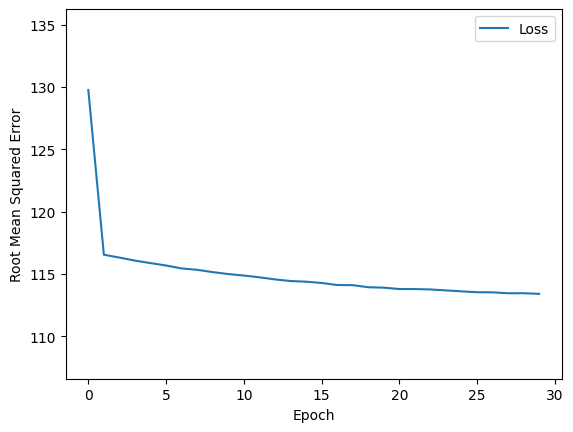


: Evaluate the new model against the test set:


/usr/local/lib/python3.10/dist-packages/keras/engine/functional.py:639: UserWarning: Input dict contained keys ['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


30/30 [==============================] - 1s 2ms/step - loss: 12231.6426 - root_mean_squared_error: 110.5968


[12231.642578125, 110.59675598144531]

In [5]:
#@title Train the model with floating-point representations

# The following variables are the hyperparameters.
learning_rate = 0.05
epochs = 30
batch_size = 100
label_name = 'median_house_value'

# The two Input layers are concatenated so they can be passed as a single
# tensor to a Dense layer.
preprocessing_layer = tf.keras.layers.Concatenate()(inputs.values())

dense_output = layers.Dense(units=1, name='dense_layer')(preprocessing_layer)

outputs = {
  'dense_output': dense_output
}

# Create and compile the model's topography.
my_model = create_model(inputs, outputs, learning_rate)

# To view a PNG of this model's layers, uncomment the call to
# `tf.keras.utils.plot_model` below. After running this code cell, click
# the file folder on the left, then the `my_model.png` file.
# tf.keras.utils.plot_model(my_model, "my_model.png", show_shapes=True)

# Train the model on the training set.
epochs, rmse = train_model(my_model, train_df, epochs, batch_size, label_name)

# Print out the model summary.
my_model.summary(expand_nested=True)

plot_the_loss_curve(epochs, rmse)

print("\n: Evaluate the new model against the test set:")
test_features = {name:np.array(value) for name, value in test_df.items()}
test_label = np.array(test_features.pop(label_name))
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)

In [6]:
#@title Represent latitude and longitude in buckets

resolution_in_degrees = 1.0

# Create a list of numbers representing the bucket boundaries for latitude.
latitude_boundaries = list(np.arange(int(min(train_df['latitude'])),
                                     int(max(train_df['latitude'])),
                                     resolution_in_degrees))
print("latitude boundaries: " + str(latitude_boundaries))

# Create a Discretization layer to separate the latitude data into buckets.
latitude = tf.keras.layers.Discretization(
    bin_boundaries=latitude_boundaries,
    name='discretization_latitude')(inputs.get('latitude'))

# Number of categories is the length of latitude_boundaries plus one.
latitude = tf.keras.layers.CategoryEncoding(
    num_tokens=len(latitude_boundaries) + 1,
    output_mode='one_hot',
    name='category_encoding_latitude')(latitude)

# Create a list of numbers representing the bucket boundaries for longitude.
longitude_boundaries = list(np.arange(int(min(train_df['longitude'])),
                                      int(max(train_df['longitude'])),
                                      resolution_in_degrees))

print("longitude boundaries: " + str(longitude_boundaries))

# Create a Discretization layer to separate the longitude data into buckets.
longitude = tf.keras.layers.Discretization(
    bin_boundaries=longitude_boundaries,
    name='discretization_longitude')(inputs.get('longitude'))

# Number of categories is the length of longitude_boundaries plus one.
longitude = tf.keras.layers.CategoryEncoding(
    num_tokens=len(longitude_boundaries) + 1,
    output_mode='one_hot',
    name='category_encoding_longitude')(longitude)

# Concatenate latitude and longitude into a single tensor as input for the Dense layer.
concatenate_layer = tf.keras.layers.Concatenate()([latitude, longitude])

dense_output = layers.Dense(units=1, name='dense_layer')(concatenate_layer)

# Define an output dictionary we'll send to the model constructor.
outputs = {
  'dense_output': dense_output
}

latitude boundaries: [32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0]
longitude boundaries: [-124.0, -123.0, -122.0, -121.0, -120.0, -119.0, -118.0, -117.0, -116.0, -115.0]


Epoch 1/35
170/170 [==============================] - 4s 6ms/step - loss: 52067.5352 - root_mean_squared_error: 228.1831
Epoch 2/35
170/170 [==============================] - 1s 4ms/step - loss: 44678.3789 - root_mean_squared_error: 211.3726
Epoch 3/35
170/170 [==============================] - 1s 4ms/step - loss: 38102.2734 - root_mean_squared_error: 195.1980
Epoch 4/35
170/170 [==============================] - 1s 4ms/step - loss: 32290.6426 - root_mean_squared_error: 179.6960
Epoch 5/35
170/170 [==============================] - 1s 4ms/step - loss: 27253.6270 - root_mean_squared_error: 165.0867
Epoch 6/35
170/170 [==============================] - 1s 3ms/step - loss: 22995.9824 - root_mean_squared_error: 151.6443
Epoch 7/35
170/170 [==============================] - 1s 3ms/step - loss: 19517.9141 - root_mean_squared_error: 139.7065
Epoch 8/35
170/170 [==============================] - 1s 4ms/step - loss: 16687.5078 - root_mean_squared_error: 129.1801
Epoch 9/35
170/170 [============

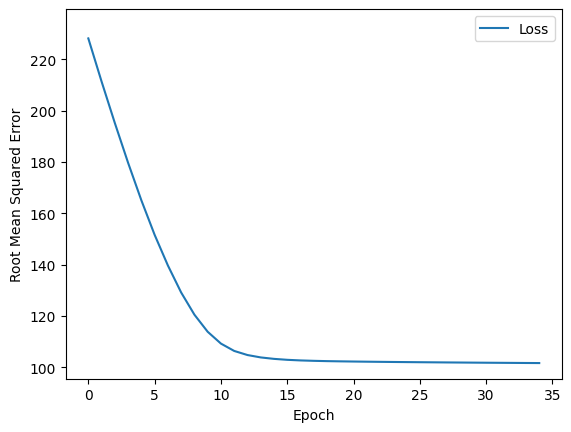


: Evaluate the new model against the test set:
 1/30 [>.............................] - ETA: 5s - loss: 6371.1592 - root_mean_squared_error: 79.8195

/usr/local/lib/python3.10/dist-packages/keras/engine/functional.py:639: UserWarning: Input dict contained keys ['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


30/30 [==============================] - 0s 2ms/step - loss: 10196.2520 - root_mean_squared_error: 100.9765


[10196.251953125, 100.97649383544922]

In [7]:
#@title Train the model with bucket representations

# The following variables are the hyperparameters.
learning_rate = 0.04
epochs = 35

# Build the model.
my_model = create_model(inputs, outputs, learning_rate)

# Train the model on the training set.
epochs, rmse = train_model(my_model, train_df, epochs, batch_size, label_name)

# Print out the model summary.
my_model.summary(expand_nested=True)

plot_the_loss_curve(epochs, rmse)

print("\n: Evaluate the new model against the test set:")
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)

In [8]:
#@title Represent location as a feature cross

resolution_in_degrees = 0.4

# Create a list of numbers representing the bucket boundaries for latitude.
latitude_boundaries = list(np.arange(int(min(train_df['latitude'])),
                                     int(max(train_df['latitude'])),
                                     resolution_in_degrees))

# Create a Discretization layer to separate the latitude data into buckets.
latitude = tf.keras.layers.Discretization(
    bin_boundaries=latitude_boundaries,
    name='discretization_latitude')(inputs.get('latitude'))

# Create a list of numbers representing the bucket boundaries for longitude.
longitude_boundaries = list(np.arange(int(min(train_df['longitude'])),
                                      int(max(train_df['longitude'])),
                                      resolution_in_degrees))

# Create a Discretization layer to separate the longitude data into buckets.
longitude = tf.keras.layers.Discretization(
    bin_boundaries=longitude_boundaries,
    name='discretization_longitude')(inputs.get('longitude'))

# Cross the latitude and longitude features into a single one-hot vector.
feature_cross = tf.keras.layers.HashedCrossing(
    num_bins=len(latitude_boundaries) * len(longitude_boundaries),
    output_mode='one_hot',
    name='cross_latitude_longitude')([latitude, longitude])

dense_output = layers.Dense(units=1, name='dense_layer')(feature_cross)

# Define an output dictionary we'll send to the model constructor.
outputs = {
  'dense_output': dense_output
}

Epoch 1/35
170/170 [==============================] - 1s 2ms/step - loss: 53700.4141 - root_mean_squared_error: 231.7335
Epoch 2/35
170/170 [==============================] - 0s 2ms/step - loss: 48932.3984 - root_mean_squared_error: 221.2067
Epoch 3/35
170/170 [==============================] - 0s 2ms/step - loss: 44511.0469 - root_mean_squared_error: 210.9764
Epoch 4/35
170/170 [==============================] - 0s 2ms/step - loss: 40344.7617 - root_mean_squared_error: 200.8601
Epoch 5/35
170/170 [==============================] - 0s 2ms/step - loss: 36479.8945 - root_mean_squared_error: 190.9971
Epoch 6/35
170/170 [==============================] - 0s 2ms/step - loss: 32916.1055 - root_mean_squared_error: 181.4280
Epoch 7/35
170/170 [==============================] - 0s 3ms/step - loss: 29639.2500 - root_mean_squared_error: 172.1605
Epoch 8/35
170/170 [==============================] - 1s 3ms/step - loss: 26653.7227 - root_mean_squared_error: 163.2597
Epoch 9/35
170/170 [============

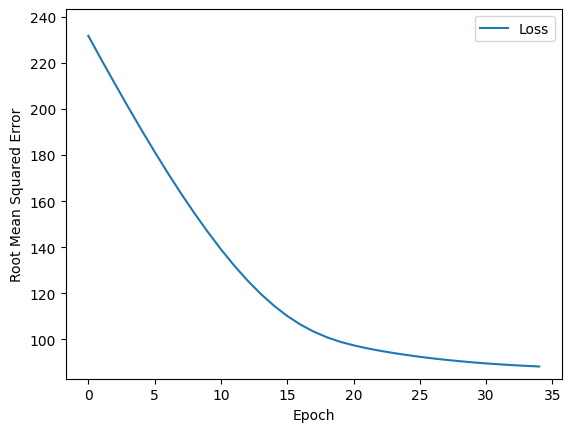


: Evaluate the new model against the test set:
30/30 [==============================] - 0s 2ms/step - loss: 7852.3965 - root_mean_squared_error: 88.6137


/usr/local/lib/python3.10/dist-packages/keras/engine/functional.py:639: UserWarning: Input dict contained keys ['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


[7852.396484375, 88.6137466430664]

In [9]:
# The following variables are the hyperparameters.
learning_rate = 0.04
epochs = 35

# Build the model, this time passing in the feature_cross_feature_layer:
my_model = create_model(inputs, outputs, learning_rate)

# Train the model on the training set.
epochs, rmse = train_model(my_model, train_df, epochs, batch_size, label_name)

# Print out the model summary.
my_model.summary(expand_nested=True)

plot_the_loss_curve(epochs, rmse)

print("\n: Evaluate the new model against the test set:")
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)